# Load necessary functions

In [ ]:
import os
dir_cache = ""
os.environ['TRANSFORMERS_CACHE'] = dir_cache
os.environ['HF_HOME'] = dir_cache
os.environ['HF_DATASETS_CACHE'] = dir_cache
os.environ['TORCH_HOME'] = dir_cache

import numpy as np
from transformers import AutoTokenizer, AutoModel
import os
from tqdm import tqdm
from huggingface_hub import login
huggingface_token = ""
login(token=huggingface_token)
import pandas as pd
import sys
dir_wd = ""
sys.path.append(dir_wd)
from utils import list_files, get_bids_fname_tag
dir_results = os.path.join(dir_wd, "results")
os.makedirs(dir_results, exist_ok=True)

def decorate_figure(fig=None, ax=None, title=None, xlabel=None, ylabel=None, ylim_l=None, ylim_h=None):
    """
    Decorate a matplotlib figure with custom styling.
    
    Parameters:
    fig : matplotlib.figure.Figure, optional
        The figure to decorate. If None, plt.gcf() will be used.
    ax : matplotlib.axes.Axes or array of Axes, optional
        The axes to decorate. If None, fig.get_axes() will be used.
    """
    if fig is None:
        fig = plt.gcf()
    if ax is None:
        ax = fig.get_axes()
    
    # If ax is a single Axes object, convert it to a list
    if not isinstance(ax, (list, np.ndarray)):
        ax = [ax]
    
    for axes in ax:
        if not ylim_h == None:
            axes.set_ylim(ylim_l, ylim_h)
        axes.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)
        axes.grid(True, axis='x', linestyle='--', color='gray', alpha=0.3)
        # axes.set_facecolor('#f0f0f0')  # Light gray background
        axes.spines['top'].set_visible(False)  # Remove top spine
        axes.spines['right'].set_visible(False)  # Remove right spine
        axes.set_xlabel(xlabel) if xlabel != None else None
        axes.set_ylabel(ylabel) if ylabel != None else None
        axes.set_title(title) if title != None else None
        
    fig.tight_layout()  # Adjust the layout
    return(fig)

# Nonlinear scaling of cosine similarity

Plot showing the nonlinear increasing 

/tmp/ipykernel_2407041/3546037242.py:17: RuntimeWarning: divide by zero encountered in divide
  derivatives = -1 / np.sqrt(1 - cos_sim_values**2)


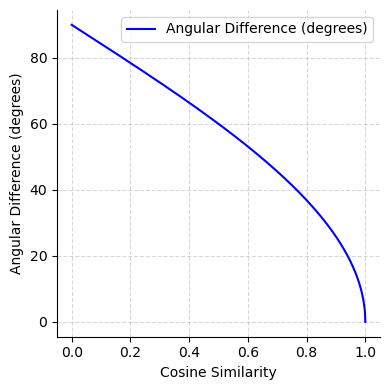

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def cos_sim_to_angle(cos_sim):
    """Convert cosine similarity to angular difference in degrees."""
    return np.degrees(np.arccos(cos_sim))

def plot_cosine_vs_angle_with_derivative():
    # Generate cosine similarity values from 0 to 1
    cos_sim_values = np.linspace(0, 1, 1000)
    
    # Calculate corresponding angular differences
    angular_diff = [cos_sim_to_angle(sim) for sim in cos_sim_values]

    # Calculate the derivative (rate of change of angle with respect to cosine similarity)
    # The derivative of arccos(x) is -1 / sqrt(1 - x^2)
    derivatives = -1 / np.sqrt(1 - cos_sim_values**2)

    # Plot the relationship
    this_fig = plt.figure(figsize=(4, 4))
    
    # Plot angular difference
    # plt.subplot(1, 2, 1)
    plt.plot(cos_sim_values, angular_diff, label="Angular Difference (degrees)", color="blue")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Angular Difference (degrees)")
    # plt.title("Cosine Similarity vs Angular Difference")
    plt.grid(True)
    plt.legend()

    # Plot derivative
    # plt.subplot(1, 2, 2)
    # plt.plot(cos_sim_values, derivatives, label="Derivative (dθ/dcos)", color="red")
    # plt.xlabel("Cosine Similarity")
    # plt.ylabel("Derivative (dθ/dcos)")
    # plt.title("Rate of Change of Cosine Similarity")
    # plt.grid(True)
    # plt.legend()

    # Show the plot
    plt.tight_layout()
    # plt.show()
    return(this_fig)

plot_cos = plot_cosine_vs_angle_with_derivative();
plot_cos = decorate_figure(plot_cos)
# plot_cos.savefig(os.path.join("results", "lexical_v20250118", "figures", "plot_cos_vs_ang.png"), bbox_inches="tight")

# Plot figures of disambiguation score

Loading preprocesed dataframe from R

In [2]:
df_sim_word_preprocessed = pd.read_feather(os.path.join("results", "lexical_v20250118", "dataframe", "df_sim_byword_preprocessed.feather"))
df_gap_preprocessed = pd.read_feather(os.path.join("results", "lexical_v20250118", "dataframe", "df_gap_preprocessed.feather"))

Convert the column back to "str" instead of being category

In [3]:
df_sim_word_preprocessed[df_sim_word_preprocessed.select_dtypes(['category']).columns] = df_sim_word_preprocessed[df_sim_word_preprocessed.select_dtypes(['category']).columns].astype(str)

df_gap_preprocessed[df_gap_preprocessed.select_dtypes(['category']).columns] = df_gap_preprocessed[df_gap_preprocessed.select_dtypes(['category']).columns].astype(str)

In [4]:
df_gap_preprocessed.head()

,word,model,layer,layer_rel,lang,POS_type,sense,gap,layer_depth
0,angle,Llama-3.1-8B,0.0,0.00000,en,diff,1,-0.143522,lower
1,angle,Llama-3.1-8B,0.0,0.00000,en,diff,2,-0.149914,lower
2,angle,Llama-3.1-8B,1.0,0.03125,en,diff,1,8.992225,lower
3,angle,Llama-3.1-8B,1.0,0.03125,en,diff,2,12.186371,lower
4,angle,Llama-3.1-8B,2.0,0.06250,en,diff,1,7.244044,lower


Averaging

In [5]:
df_sim_mean = df_sim_word_preprocessed.groupby(by=["word", "layer", "model"]).agg({"angle_sim_adj": "mean", "layer_rel": "first"}).reset_index()
# df_sim_mean.head()
df_sim_mean

,word,layer,model,angle_sim_adj,layer_rel
0,angle,0.0,Llama-3.1-8B,83.438581,0.000000
1,angle,0.0,Llama-3.2-1B,84.811586,0.000000
2,angle,0.0,Llama-3.2-3B,85.930851,0.000000
3,angle,0.0,Qwen2.5-1.5B,85.759212,0.000000
4,angle,0.0,Qwen2.5-3B,85.808533,0.000000
...,...,...,...,...,...
92695,鱼白,44.0,gpt2-xl,-1.742234,0.916667
92696,鱼白,45.0,gpt2-xl,-0.171246,0.937500
92697,鱼白,46.0,gpt2-xl,5.543008,0.958333
92698,鱼白,47.0,gpt2-xl,13.120960,0.979167


In [6]:
df_gap_mean = df_gap_preprocessed.groupby(by=["model", "layer", "lang"]).agg({"gap": "mean", "layer_rel": "first"}).reset_index()
df_gap_mean.head()

,model,layer,lang,gap,layer_rel
0,Llama-3.1-8B,0.0,en,-0.203542,0.00000
1,Llama-3.1-8B,0.0,zh,-0.000621,0.00000
2,Llama-3.1-8B,1.0,en,6.761254,0.03125
3,Llama-3.1-8B,1.0,zh,1.409752,0.03125
4,Llama-3.1-8B,2.0,en,9.086806,0.06250


# Plotting

Define the model names that has been examined in the present study.

In [7]:
list_gpt2_model_name = ["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"]
list_zh_bert_model_name = ["bert-base-chinese", "bert-base-multilingual-uncased", "roberta-base", "roberta-large", "xlm-roberta-base", "xlm-roberta-large", "deberta-v3-base", "deberta-v3-large", "mdeberta-v3-base"]
list_en_bert_model_name = ["bert-base-uncased", "bert-large-uncased", "bert-base-multilingual-uncased", "roberta-base", "roberta-large", "xlm-roberta-base", "xlm-roberta-large", "deberta-v3-base", "deberta-v3-large", "mdeberta-v3-base"]
list_both_bert_model_name = ["bert-base-uncased", "bert-large-uncased", "bert-base-chinese", "bert-base-multilingual-uncased", "roberta-base", "roberta-large", "xlm-roberta-base", "xlm-roberta-large", "deberta-v3-base", "deberta-v3-large", "mdeberta-v3-base"]

list_llama_model_name = ["Llama-3.2-1B", "Llama-3.2-3B", "Llama-3.1-8B"]
list_qwen_model_name = ["Qwen2.5-1.5B", "Qwen2.5-3B", "Qwen2.5-7B"]
list_zh_model_name = list_zh_bert_model_name + list_gpt2_model_name + list_llama_model_name + list_qwen_model_name
list_en_model_name = list_en_bert_model_name + list_gpt2_model_name + list_llama_model_name + list_qwen_model_name
list_all_model_name = list_both_bert_model_name + list_gpt2_model_name + list_llama_model_name + list_qwen_model_name
list_model_fam = [list_both_bert_model_name, list_gpt2_model_name, list_llama_model_name, list_qwen_model_name]

print(len(list_en_model_name))

20


# Figure: Disambiguation gap computed from English homonyms across different models

The D-score, aka gap, is computed as the same-sense angular similarity - cross-sense angular similarity.

A higher D-score (higher gap) suggests a better contextual disambiguation ability of the model at that particular layer.

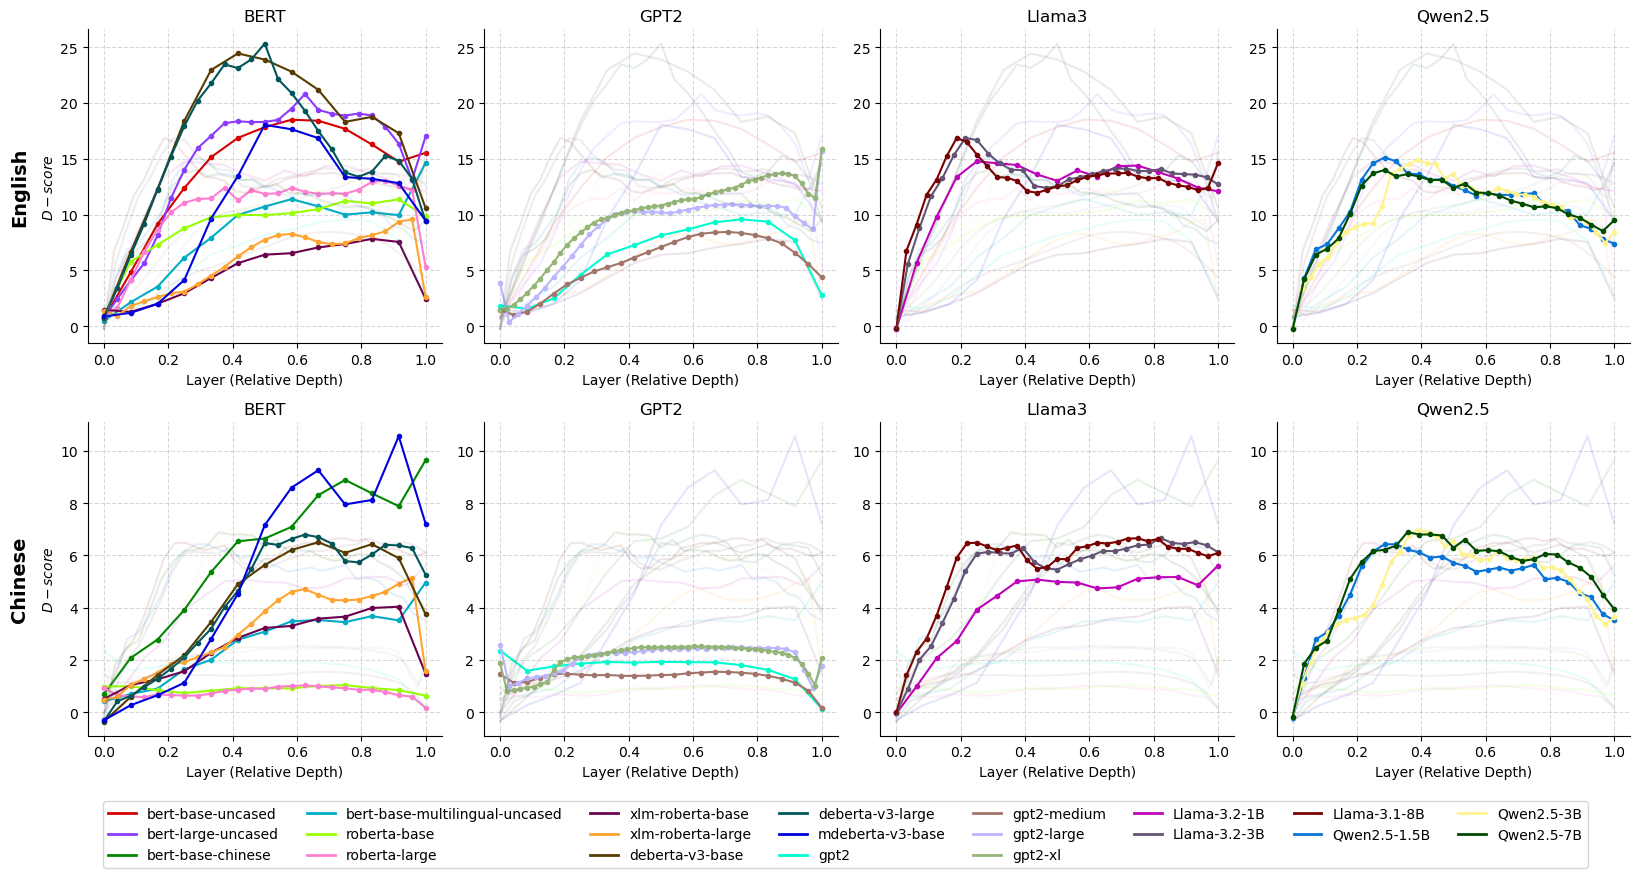

In [11]:
import matplotlib.pyplot as plt
# ------------------------------
# Define parameters
# First of all make a color palette with many elements.
# ------------------------------
import colorcet as cc
import seaborn as sns
color_palette = sns.color_palette(cc.glasbey, n_colors=len(list_all_model_name))
layer_type = "layer_rel"
this_lang = "en"
list_cos_sim = ["angle", "angle_b", "angle_diff"]
list_cos_sim_label = ["Angle", "Baseline", "Difference"]
list_linestyle = ['-', '--', ':']
list_model_fam_name = ["BERT", "GPT2", "Llama3", "Qwen2.5"]

# ------------------------------
# REAL PLOTTING STARTS HERE
fig, axes  = plt.subplots(2, 4, squeeze=True, figsize=(16,8))
axes = axes.ravel()

idx_cos_sim = 0 
for idx_fam in range(len(list_model_fam)):    
    for idx_model, model_name in enumerate(list_en_model_name):
        df_this = df_gap_mean.loc[(df_gap_mean.lang == this_lang) & # Filter by language and model
                        (df_gap_mean.model == model_name)]
        idx_in_all_models = list_all_model_name.index(model_name)
        if model_name in list_model_fam[idx_fam]:
            this_alpha = 1
            df_this.plot(x=layer_type, y="gap", ax=axes[idx_fam], label=list_all_model_name[idx_in_all_models], alpha=this_alpha, marker="o", linestyle=list_linestyle[idx_cos_sim], color=color_palette[idx_in_all_models], markersize=3)
        else:
            this_alpha = 0.1
            df_this.plot(x=layer_type, y="gap", ax=axes[idx_fam], label=list_all_model_name[idx_in_all_models], alpha=this_alpha, linestyle='-', color=color_palette[idx_in_all_models])
        axes[idx_fam].get_legend().remove()
        axes[idx_fam].set_title(list_model_fam_name[idx_fam])

this_lang = "zh"
for idx_fam in range(len(list_model_fam)):
    idx_fam = idx_fam + 4   
    for idx_model, model_name in enumerate(list_zh_model_name):
        df_this = df_gap_mean.loc[(df_gap_mean.lang == this_lang) & # Filter by language and model
                        (df_gap_mean.model == model_name)]
        idx_in_all_models = list_all_model_name.index(model_name)

        if model_name in list_model_fam[idx_fam-4]:
            this_alpha = 1
            df_this.plot(x=layer_type, y="gap", ax=axes[idx_fam], label=list_all_model_name[idx_in_all_models], alpha=this_alpha, marker="o", linestyle=list_linestyle[idx_cos_sim], color=color_palette[idx_in_all_models], markersize=3)
        else:
            this_alpha = 0.1
            df_this.plot(x=layer_type, y="gap", ax=axes[idx_fam], label=list_all_model_name[idx_in_all_models], alpha=this_alpha, linestyle='-', color=color_palette[idx_in_all_models])

        axes[idx_fam].get_legend().remove()
        axes[idx_fam].set_title(list_model_fam_name[idx_fam-4])

# ------------------------------
# FIGURE DECORATION

# Normal
# fig = decorate_figure(fig=fig, ax=axes[0:4], xlabel="Layer (Relative Depth)", ylabel=r"$D-score$", ylim_l=0, ylim_h=90)
# fig = decorate_figure(fig=fig, ax=axes[4:8], xlabel="Layer (Relative Depth)", ylabel=r"$D-score$", ylim_l=0, ylim_h=90)

# Use the following if you want same scales for English and Chinese results
# fig = decorate_figure(fig=fig, ax=axes[0:4], xlabel="Layer (Relative Depth)", ylabel="", ylim_l=-0.5, ylim_h=30)
# fig = decorate_figure(fig=fig, ax=axes[4:8], xlabel="Layer (Relative Depth)", ylabel="", ylim_l=-0.5, ylim_h=30)
# handles, labels = axes[0].get_legend_handles_labels()

# Use the following if you want different scale for English and Chinese result
fig = decorate_figure(fig=fig, ax=axes[0:4], xlabel="Layer (Relative Depth)", ylabel="", ylim_l=None, ylim_h=None)
fig = decorate_figure(fig=fig, ax=axes[4:8], xlabel="Layer (Relative Depth)", ylabel="", ylim_l=None, ylim_h=None)
handles, labels = axes[0].get_legend_handles_labels()

# Create custom legend handles with full opacity
from matplotlib.lines import Line2D
custom_handles = [Line2D([0], [0], color=color_palette[i], lw=2) for i in range(len(list_all_model_name))]
custom_labels = [f"{list_all_model_name[i]}" for i in range(len(list_all_model_name))]

# Define the label of the y-axis
axes[0].text(-0.13, 0.5, r"$D-score$", rotation=90, transform=axes[0].transAxes, va='center')
axes[4].text(-0.13, 0.5, r"$D-score$", rotation=90, transform=axes[4].transAxes, va='center')
axes[0].text(-0.22, 0.5, 'English', rotation=90, fontsize=14, weight="bold", transform=axes[0].transAxes, va='center')
axes[4].text(-0.22, 0.5, 'Chinese', rotation=90, fontsize=14, weight="bold", transform=axes[4].transAxes, va='center')

# Create a single legend for the entire figure using custom handles
fig.legend(custom_handles, custom_labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=8)
# ------------------------------

# ------------------------------
# SAVE THE FIGURE

# Same scale
# fig.savefig(os.path.join("results", "lexical_v20250118", "figures", "plot_gap_scale-same.png"), bbox_inches="tight", dpi=300)

# Different scales
fig.savefig(os.path.join("results", "lexical_v20250118", "figures", "plot_gap.png"), bbox_inches="tight", dpi=300)

# ------------------------------